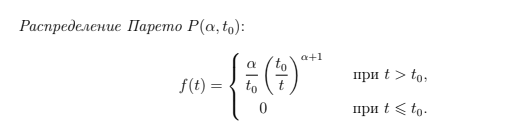



Средняя наработка (T_ср): 9.5181
Дисперсия: 125.3384
СКО: 11.1955
Гамма (%)    | T_gamma (часов)
------------------------------
100          | 5.0000         
90           | 5.2573         
80           | 5.5605         
70           | 5.9256         
60           | 6.3769         
50           | 6.9553         
40           | 7.7351         
30           | 8.8707         
20           | 10.7600        
10           | 14.9679        


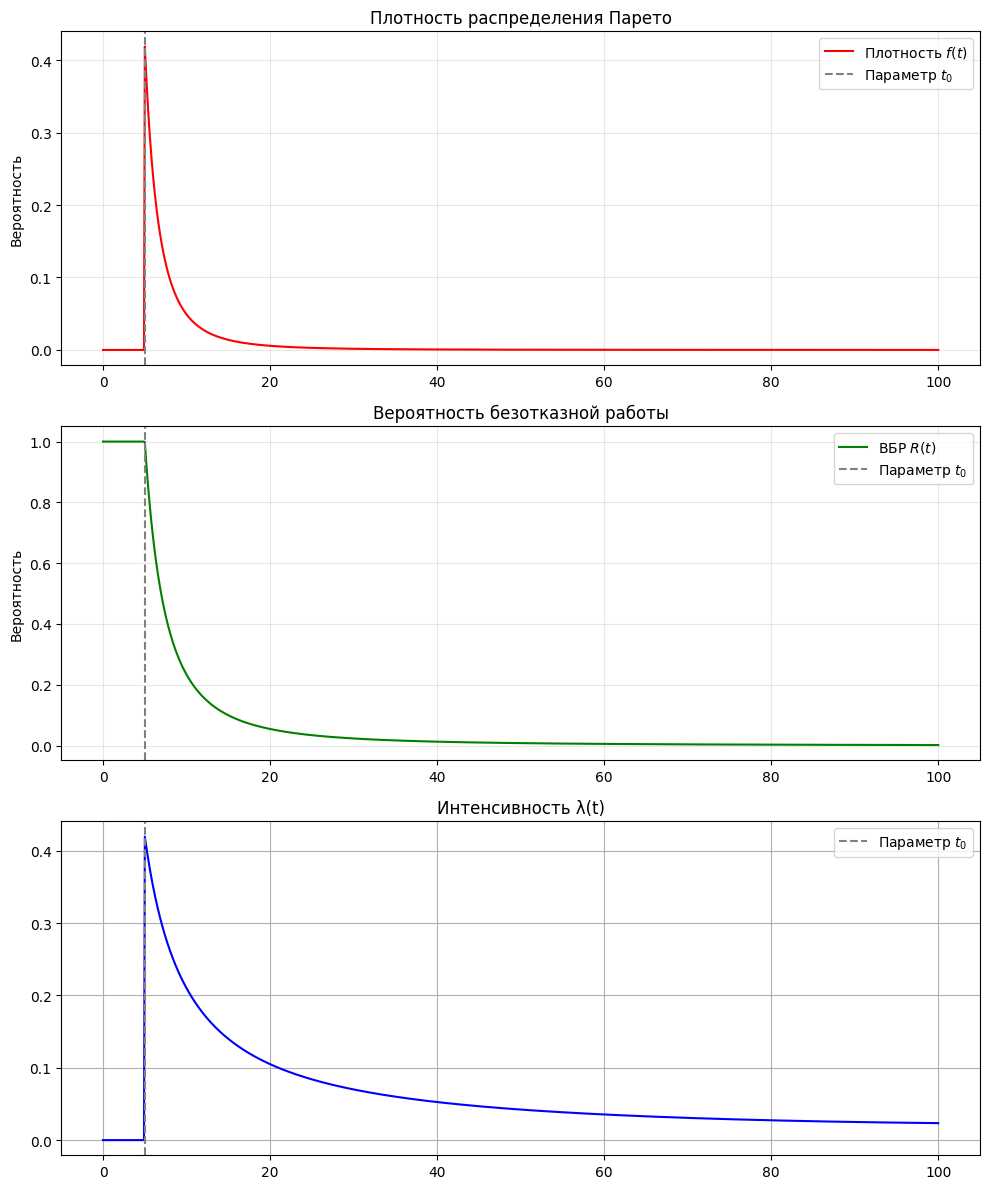

In [15]:
import math

# Pareto params
alpha = 2.1
t_0 = 5

def integrate_by_trapezoid(f, start, end, n):
    step = (end - start) / n

    integral_sum = (f(start) + f(end)) / 2

    for i in range(1, n):
        x = start + i * step
        integral_sum += f(x)

    return step * integral_sum

# f(t)
def pareto_pdf(t):
    if t < t_0:
        return 0
    return (alpha / t_0) * ((t_0 / t))**(alpha + 1)

# R(t)
def pareto_reliability(t):
    if t <= t_0:
        return 1
    P_t = integrate_by_trapezoid(f = pareto_pdf, start = t_0, end = t, n = 1000)
    R_t = 1 - P_t

    if R_t < 0:
        R_t = 0
    if R_t > 1:
        R_t = 1

    return R_t

# T_m, mean time to failure, M[T]
def pareto_mttf():
    return integrate_by_trapezoid(f=(lambda t: t * pareto_pdf(t)), start=t_0, end=1000, n=10000)

# Lamb(t), failure intensity
def pareto_intensity(t):
    eps = 1e-5
    rel = pareto_reliability(t)
    if rel > eps:
        return pareto_pdf(t) / rel 
    else:
        return 0


# D[T]
def pareto_variance(mttf):
    sec_moment = integrate_by_trapezoid(
        f=(lambda t: (t**2) * pareto_pdf(t)), start=t_0, end=1000, n=10000
    )
    return sec_moment - (mttf**2)

# Sigma, std deviation
def pareto_deviation(variance):
    return math.sqrt(variance)

# Gamma, gamma work time
def get_pareto_gamma_worktime():
    gamma_list = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
    results = {}
    for g in gamma_list:
        if g <= 0:
            results[g] = float("inf")
        elif g > 100:
            results[g] = 0
        else:
            t_gamma = t_0 / ((g / 100.0) ** (1 / alpha))
            results[g] = t_gamma
    return results


mttf = pareto_mttf()
var = pareto_variance(mttf)
std_dev = pareto_deviation(var)
gamma_vals = get_pareto_gamma_worktime()

print(f"Средняя наработка (T_ср): {mttf:.4f}")
print(f"Дисперсия: {var:.4f}")
print(f"СКО: {std_dev:.4f}")
print(f"{'Гамма (%)':<12} | {'T_gamma (часов)':<15}")
print("-" * 30)
for g in gamma_vals:
    print(f"{g:<12} | {gamma_vals[g]:<15.4f}")


# Plots
import numpy as np
import matplotlib.pyplot as plt

t_vals = np.linspace(0, 100, 1000)
pdf_vals = [pareto_pdf(t) for t in t_vals]
rel_vals = [pareto_reliability(t) for t in t_vals]
lambd_vals = [pareto_intensity(t) for t in t_vals]

plt.figure(figsize=(10, 12))

# f(t)
plt.subplot(3, 1, 1)
plt.plot(t_vals, pdf_vals, color="red", label="Плотность $f(t)$")
plt.axvline(x=t_0, color="gray", linestyle="--", label="Параметр $t_0$")
plt.title("Плотность распределения Парето")
plt.ylabel("Вероятность")
plt.legend()
plt.grid(True, alpha=0.3)

# R(t)
plt.subplot(3, 1, 2)
plt.plot(t_vals, rel_vals, color="green", label="ВБР $R(t)$")
plt.axvline(x=t_0, color="gray", linestyle="--", label="Параметр $t_0$")
plt.title("Вероятность безотказной работы")
plt.ylabel("Вероятность")
plt.legend()
plt.grid(True, alpha=0.3)

# λ(t)
plt.subplot(3, 1, 3)
plt.plot(t_vals, lambd_vals, "b")
plt.axvline(x=t_0, color="gray", linestyle="--", label="Параметр $t_0$")
plt.title("Интенсивность λ(t)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**TN, усеченное нормальное распределение**

In [ ]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

# Параметры
mu, sigma2 = 400, 9095
sigma = np.sqrt(sigma2)
a, b = 0, np.inf

tn = truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)


# 1. R(t)
def R(t):
    return 1 - tn.cdf(t)


# 2. MTTF
MTTF = tn.mean()

# 3. Дисперсия и СКО
var = tn.var()
std = np.sqrt(var)


# 4. λ(t)
def lamb(t):
    return tn.pdf(t) / R(t) if R(t) > 1e-12 else np.inf


# 5. f(t)
def f(t):
    return tn.pdf(t)


# 6. t_γ
def t_gamma(gamma):
    return tn.ppf(gamma / 100) if 0 < gamma < 100 else (np.inf if gamma == 0 else 0)


# Результаты
print(f"Ожидание = {MTTF:.1f} ч")
print(f"СКО = {std:.1f} ч")
print(f"t_50 = {t_gamma(50):.1f} ч")
print(f"t_10 = {t_gamma(10):.1f} ч")

# Графики
t = np.linspace(0, 800, 500)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(t, [R(x) for x in t])
axes[0, 0].set_title("R(t)")
axes[0, 1].plot(t, [f(x) for x in t])
axes[0, 1].set_title("f(t)")
axes[1, 0].plot(t, [lamb(x) for x in t])
axes[1, 0].set_title("λ(t)")

gamma_range = np.arange(0, 101, 10)
t_g = [t_gamma(g) for g in gamma_range]
axes[1, 1].plot(gamma_range, t_g)
axes[1, 1].set_title("t_γ")

plt.tight_layout()
plt.show()

**Система из 3 элементов целиком**

MTTF системы = 12.75 ч
Дисперсия = 41.50
СКО = 6.44
Гамма-процентная наработка:
γ=0% → t_γ = inf ч
γ=10% → t_γ = 14.96 ч
γ=20% → t_γ = 10.75 ч
γ=30% → t_γ = 8.87 ч
γ=40% → t_γ = 7.73 ч
γ=50% → t_γ = 6.95 ч
γ=60% → t_γ = 6.37 ч
γ=70% → t_γ = 5.92 ч
γ=80% → t_γ = 5.56 ч
γ=90% → t_γ = 5.26 ч
γ=100% → t_γ = 0.00 ч


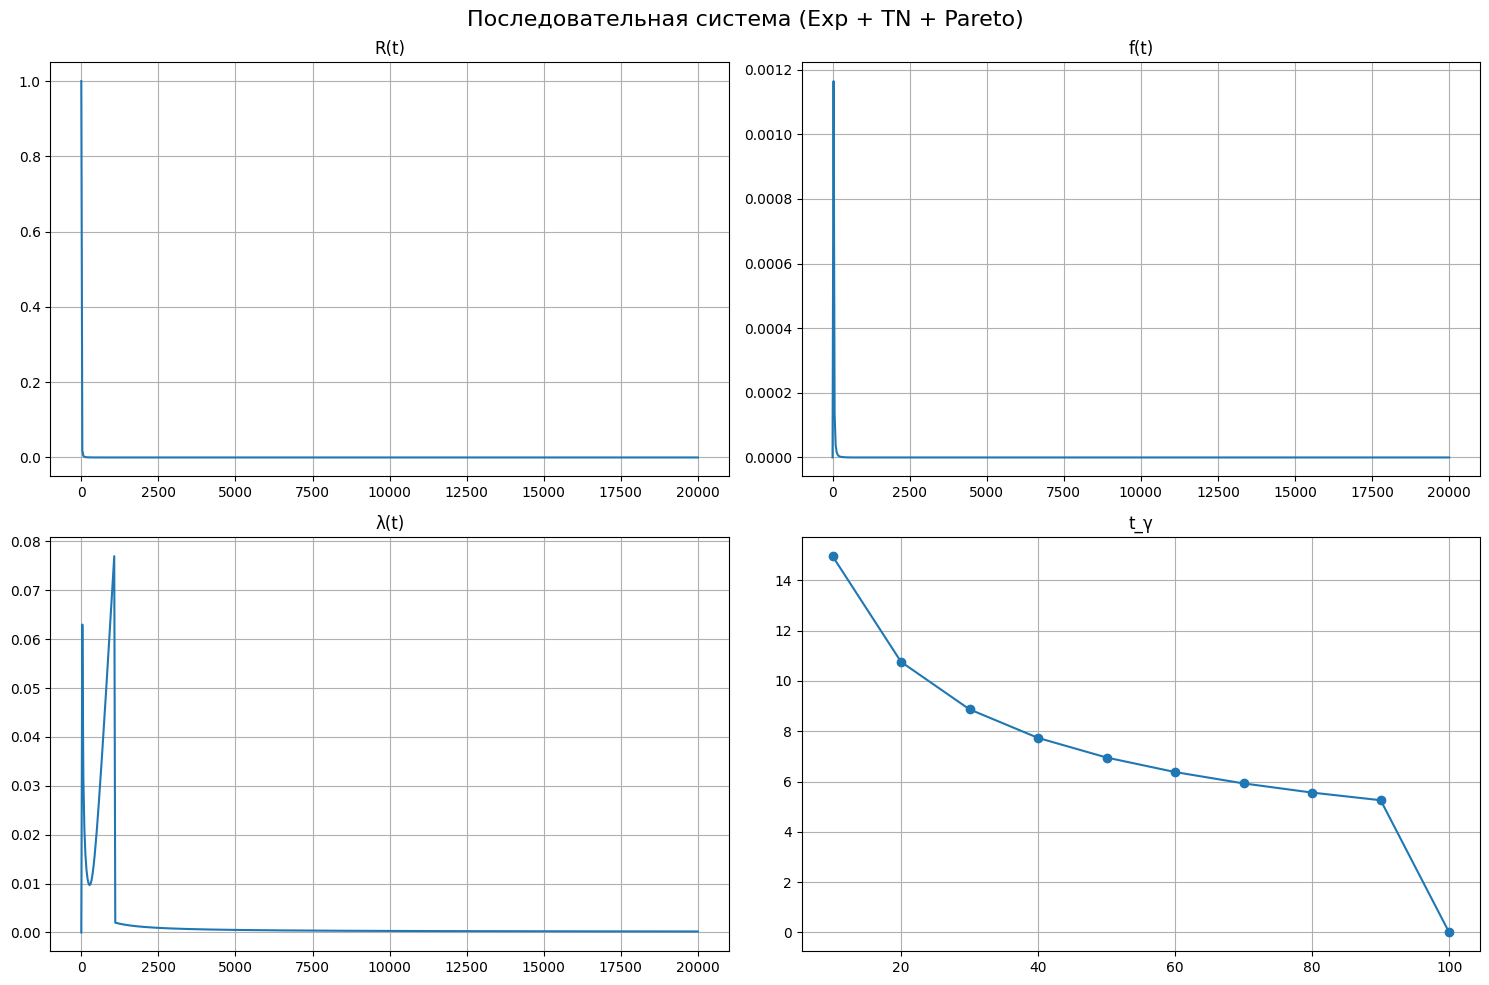

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy import optimize

# ===============================
# ПАРАМЕТРЫ ЭЛЕМЕНТОВ
# ===============================

# 1. Экспоненциальное
lam = 1e-4

# 2. Усечённое нормальное
mu = 400
sigma2 = 9095
sigma = np.sqrt(sigma2)
tn = truncnorm((0 - mu) / sigma, np.inf, loc=mu, scale=sigma)

# 3. Парето
alpha = 2.1
xm = 5


# ===============================
# PDF элементов
# ===============================


def exp_pdf(t):
    return lam * np.exp(-lam * t) if t > 0 else 0


def tn_pdf(t):
    return tn.pdf(t) if t > 0 else 0


def pareto_pdf(t):
    return alpha * xm**alpha / t ** (alpha + 1) if t >= xm else 0


# ===============================
# CDF элементов
# ===============================


def exp_cdf(t):
    return 1 - np.exp(-lam * t) if t > 0 else 0


def tn_cdf(t):
    return tn.cdf(t) if t > 0 else 0


def pareto_cdf(t):
    return 1 - (xm / t) ** alpha if t >= xm else 0


# ===============================
# НАДЁЖНОСТЬ элементов
# ===============================


def exp_R(t):
    return np.exp(-lam * t)


def tn_R(t):
    return 1 - tn_cdf(t)


def pareto_R(t):
    return 1 if t < xm else (xm / t) ** alpha



def exp_lambda(t):
    return lam if t > 0 else 0


def tn_lambda(t):
    r = tn_R(t)
    return tn_pdf(t) / r if r > 1e-12 else 0


def pareto_lambda(t):
    return alpha / t if t >= xm else 0

def system_reliability(t):
    return exp_R(t) * tn_R(t) * pareto_R(t)


def system_cdf(t):
    return 1 - system_reliability(t)


def system_pdf(t):
    if t <= 0:
        return 0
    return (
        exp_pdf(t) * tn_R(t) * pareto_R(t)
        + tn_pdf(t) * exp_R(t) * pareto_R(t)
        + pareto_pdf(t) * exp_R(t) * tn_R(t)
    )


def system_failure_rate(t):
    return exp_lambda(t) + tn_lambda(t) + pareto_lambda(t)


def system_mean_time(n=10000):
    t_max = 50000
    step = t_max / n
    integral = 0

    for i in range(n):
        t = i * step
        integral += system_reliability(t)

    return integral * step


def system_variance(m, n=10000):
    t_max = 50000
    step = t_max / n
    integral = 0

    for i in range(n):
        t = i * step
        integral += t * system_reliability(t)

    e_t2 = 2 * integral * step
    return e_t2 - m**2


def system_gamma_percent(gamma_percent):
    if gamma_percent <= 0:
        return np.inf
    if gamma_percent >= 100:
        return 0

    def eq(t):
        return system_reliability(t) - gamma_percent / 100

    sol = optimize.root_scalar(eq, bracket=[0, 50000], method="bisect")
    return sol.root


mean_sys = system_mean_time()
var_sys = system_variance(mean_sys)
std_sys = np.sqrt(var_sys)

print(f"MTTF системы = {mean_sys:.2f} ч")
print(f"Дисперсия = {var_sys:.2f}")
print(f"СКО = {std_sys:.2f}")

print("Гамма-процентная наработка:")
for g in range(0, 101, 10):
    print(f"γ={g}% → t_γ = {system_gamma_percent(g):.2f} ч")


t_values = np.linspace(0, 20000, 600)
gamma_values = np.arange(0, 101, 10)

plt.figure(figsize=(15, 10))
plt.suptitle("Последовательная система (Exp + TN + Pareto)", fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(t_values, [system_reliability(t) for t in t_values])
plt.title("R(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(t_values, [system_pdf(t) for t in t_values])
plt.title("f(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(t_values, [system_failure_rate(t) for t in t_values])
plt.title("λ(t)")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(gamma_values, [system_gamma_percent(g) for g in gamma_values], marker="o")
plt.title("t_γ")
plt.grid()

plt.tight_layout()
plt.show()